In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#! pip install kaggle
#! mkdir ~/.kaggle
#!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
#!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
#!unzip /content/Gtsrb-german-traffic-sign.zip -d /content/drive/MyDrive/Gtrsb

In [3]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
# Before starting, clear the memory

torch.cuda.empty_cache()

In [10]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [11]:
# Defining hyperparameters

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [12]:

train_data_path = "/content/drive/MyDrive/Gtrsb/Train"

In [13]:
# Define path of training data

train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 31367
Number of validation samples = 7842


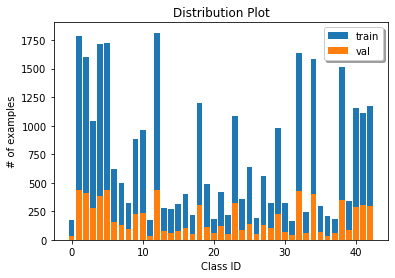

In [14]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [15]:
# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [16]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [17]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [18]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('dropout',nn.Dropout(p=0.4)),
                          ('fc1', nn.Linear(9216, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 1024)),
                          ('relu', nn.ReLU()),
                          ('output', nn.LogSoftmax(dim=1)),
                          ('fc3', nn.Linear(1024, 43)),
                          ]))
    
model.classifier = classifier

In [19]:
# Define optimizer and criterion functions

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [20]:
# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


In [21]:
# Print model

print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (dropout): Dropout(p=0.4, inplace=False)
    (fc1): Linear(in_features=9216, out_features=4096, bias

In [22]:
# Print model's state dict

print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")


Model's state dict:
features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.fc1.weight 	 torch.Size([4096, 9216])
classifier.fc1.bias 	 torch.Size([4096])
classifier.fc2.weight 	 torch.Size([1024, 4096])
classifier.fc2.bias 	 torch.Size([1024])
classifier.fc3.weight 	 torch.Size([43, 1024])
classifier.fc3.bias 	 torch.Size([43])



In [23]:
# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)



In [24]:
# Function to calculate accuracy

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [25]:
# Function to perform training of the model

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for i, data in enumerate(loader, 0):
        images, labels = data[0].cuda(), data[1].cuda()
        # images = images.cuda()
        # labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return (epoch_loss / len(loader), epoch_acc / len(loader))

In [26]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            #images, labels = data[0].cuda(), data[1].cuda()
        # for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return (epoch_loss / len(loader), epoch_acc / len(loader))

In [27]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 6.2641, Accuracy = 0.3122, Time = 9801.27 seconds
Validation: Loss = 1.5692, Accuracy = 0.5263, Time = 2026.78 seconds

Epoch-1: 
Training: Loss = 1.1328, Accuracy = 0.6439, Time = 53.00 seconds
Validation: Loss = 0.9135, Accuracy = 0.7011, Time = 13.07 seconds

Epoch-2: 
Training: Loss = 0.7928, Accuracy = 0.7444, Time = 52.90 seconds
Validation: Loss = 0.6535, Accuracy = 0.7872, Time = 12.81 seconds

Epoch-3: 
Training: Loss = 0.6239, Accuracy = 0.7986, Time = 52.86 seconds
Validation: Loss = 0.7130, Accuracy = 0.7858, Time = 13.11 seconds

Epoch-4: 
Training: Loss = 0.5594, Accuracy = 0.8179, Time = 52.98 seconds
Validation: Loss = 0.6364, Accuracy = 0.7986, Time = 13.00 seconds

Epoch-5: 
Training: Loss = 0.4968, Accuracy = 0.8413, Time = 53.38 seconds
Validation: Loss = 0.5853, Accuracy = 0.8209, Time = 12.75 seconds

Epoch-6: 
Training: Loss = 0.4613, Accuracy = 0.8489, Time = 53.67 seconds
Validation: Loss = 0.4347, Accuracy = 0.8712, Time = 13.07 seco

In [33]:

torch.save(model.state_dict(), 'saved_model.pt')


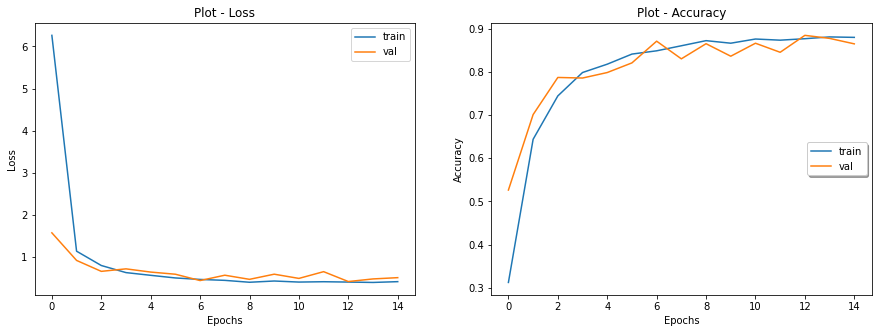

In [29]:
# Plot loss and accuracies for training and validation data

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [37]:
from PIL import Image

In [42]:
N = 5000
import pandas as pd
current_path = '/content/drive/MyDrive'
test_model_data = pd.read_csv(open(os.path.join(current_path, 'Gtrsb', 'Test.csv'), "rb"))
y_test_labels = test_model_data['ClassId'][:N]
img_paths = test_model_data['Path'][:N]
x_test_labels = []
for img in img_paths:
    image = Image.open(os.path.join(current_path, 'Gtrsb',img))
    image = image.resize((30,30))
    x_test_labels.append(np.array(image))
x_test_labels = np.array(x_test_labels)

In [43]:
X_test_labels_tensor = torch.from_numpy(np.transpose(x_test_labels, (0, 3, 1, 2))).float()
y_test_labels_tensor = torch.from_numpy(y_test_labels.values).long()

In [47]:
# this is what you had
X_test_labels_tensor = X_test_labels_tensor.cuda() 
y_test_labels_tensor = y_test_labels_tensor.cuda()

In [50]:
model.eval()
y_test_outputs = model(X_test_labels_tensor)
_, y_test_preds = torch.max(y_test_outputs, 1)
acc = torch.sum(y_test_preds == y_test_labels_tensor.data).float()/len(y_test_labels)
print(f"{acc:.2%}")
